# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input

In [ ]:
def plot_time_series(data, columns=None, figsize=(12, 6)):

    if columns is None:
        columns = data.columns
    plt.figure(figsize=figsize)
    for column in columns:
        plt.plot(data.index, data[column], label=column)
    plt.title('Time Series Visualisation')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_individual_series(data, figsize=(12, 4)):
    for column in data.columns:
        plt.figure(figsize=figsize)
        plt.plot(data.index, data[column], label=column, color='b')
        plt.title(f'Time Series Visualisation - {column}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_correlation_matrix(data):
    corr_matrix = data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title('Correlation Matris')
    plt.show()

def plot_with_anomalies(data, anomalies, column, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    plt.plot(data.index, data[column], label=f'Normal {column}')
    plt.scatter(anomalies.index, anomalies[column], color='red', label='Anomaly', zorder=5)
    plt.title(f'{column} Over Time with Anomalies Highlighted')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(time, true_values, predictions, title):
    plt.figure(figsize=(15, 5))
    plt.plot(time, true_values, label='True Values')
    plt.plot(time, predictions, label='Predicted Values', alpha=0.7)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Temp')
    plt.legend()
    plt.grid(True)
    plt.show()

# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/malmo_one_year.csv"

In [ ]:
df = pd.read_csv(data_path)
df.head()

,dt_iso,temp,humidity,wind_speed,clouds_all,pressure,dew_point
0,2022-12-31 23:00:00+00:00,282.10,92,0.45,100,998,280.87
1,2023-01-01 00:00:00+00:00,282.06,94,2.30,100,998,281.15
2,2023-01-01 01:00:00+00:00,282.45,96,3.30,100,997,281.85
3,2023-01-01 02:00:00+00:00,283.25,95,4.50,100,997,282.49
4,2023-01-01 03:00:00+00:00,283.06,96,13.40,100,997,282.45


In [ ]:
df.shape

(8761, 7)

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df.describe()

,temp,humidity,wind_speed,clouds_all,pressure,dew_point
count,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000
mean,282.988909,77.431686,4.575376,64.264011,1009.922612,278.979982
std,6.986704,14.166828,3.190479,37.641924,12.008072,6.231148
min,265.430000,30.000000,0.000000,0.000000,966.000000,262.360000
25%,277.410000,68.000000,2.200000,29.000000,1001.000000,274.220000
50%,282.190000,81.000000,4.050000,80.000000,1011.000000,278.630000
75%,289.070000,89.000000,6.200000,100.000000,1019.000000,284.210000
max,299.900000,100.000000,25.200000,100.000000,1041.000000,293.840000


In [ ]:
df['temp_celsius'] = df['temp'] - 273.15

In [ ]:
df[['temp', 'temp_celsius']].head()

,temp,temp_celsius
0,282.10,8.95
1,282.06,8.91
2,282.45,9.30
3,283.25,10.10
4,283.06,9.91


In [ ]:
df.describe()

,temp,humidity,wind_speed,clouds_all,pressure,dew_point,temp_celsius
count,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000
mean,282.988909,77.431686,4.575376,64.264011,1009.922612,278.979982,9.838909
std,6.986704,14.166828,3.190479,37.641924,12.008072,6.231148,6.986704
min,265.430000,30.000000,0.000000,0.000000,966.000000,262.360000,-7.720000
25%,277.410000,68.000000,2.200000,29.000000,1001.000000,274.220000,4.260000
50%,282.190000,81.000000,4.050000,80.000000,1011.000000,278.630000,9.040000
75%,289.070000,89.000000,6.200000,100.000000,1019.000000,284.210000,15.920000
max,299.900000,100.000000,25.200000,100.000000,1041.000000,293.840000,26.750000


In [ ]:
df['date'] = pd.to_datetime(df['dt_iso']).dt.date

In [ ]:
df[['dt_iso', 'date']].head()

,dt_iso,date
0,2022-12-31 23:00:00+00:00,2022-12-31
1,2023-01-01 00:00:00+00:00,2023-01-01
2,2023-01-01 01:00:00+00:00,2023-01-01
3,2023-01-01 02:00:00+00:00,2023-01-01
4,2023-01-01 03:00:00+00:00,2023-01-01


In [ ]:
df = df.drop(columns=['dt_iso', 'temp'])

In [ ]:
df.head()

,humidity,wind_speed,clouds_all,pressure,dew_point,temp_celsius
date,,,,,,
2022-12-31,92,0.45,100,998,280.87,8.95
2023-01-01,94,2.30,100,998,281.15,8.91
2023-01-01,96,3.30,100,997,281.85,9.30
2023-01-01,95,4.50,100,997,282.49,10.10
2023-01-01,96,13.40,100,997,282.45,9.91


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   humidity      8761 non-null   int64         
 1   wind_speed    8761 non-null   float64       
 2   clouds_all    8761 non-null   int64         
 3   pressure      8761 non-null   int64         
 4   dew_point     8761 non-null   float64       
 5   temp_celsius  8761 non-null   float64       
 6   date          8761 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 479.2 KB


In [ ]:
df['date'].is_monotonic_increasing

True

In [ ]:
# df.set_index('date', inplace=True)

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.set_index('date', inplace=True)

In [ ]:
df.index.max()

Timestamp('2023-12-31 00:00:00')

In [ ]:
df.index.min()

Timestamp('2022-12-31 00:00:00')

In [ ]:
df = df.resample('D').mean()

In [ ]:
df.head()

,humidity,wind_speed,clouds_all,pressure,dew_point,temp_celsius
date,,,,,,
2022-12-31,92.000000,0.450000,100.000000,998.000000,280.870000,8.950000
2023-01-01,90.791667,8.787500,96.000000,1003.916667,281.007917,9.292917
2023-01-02,93.500000,7.887500,91.833333,1008.041667,279.700833,7.535000
2023-01-03,87.083333,8.070833,46.500000,1018.583333,275.953333,4.784583
2023-01-04,94.958333,11.200000,99.791667,1003.166667,278.899583,6.497083


# Time Series Analysis

## Visualisation of Series

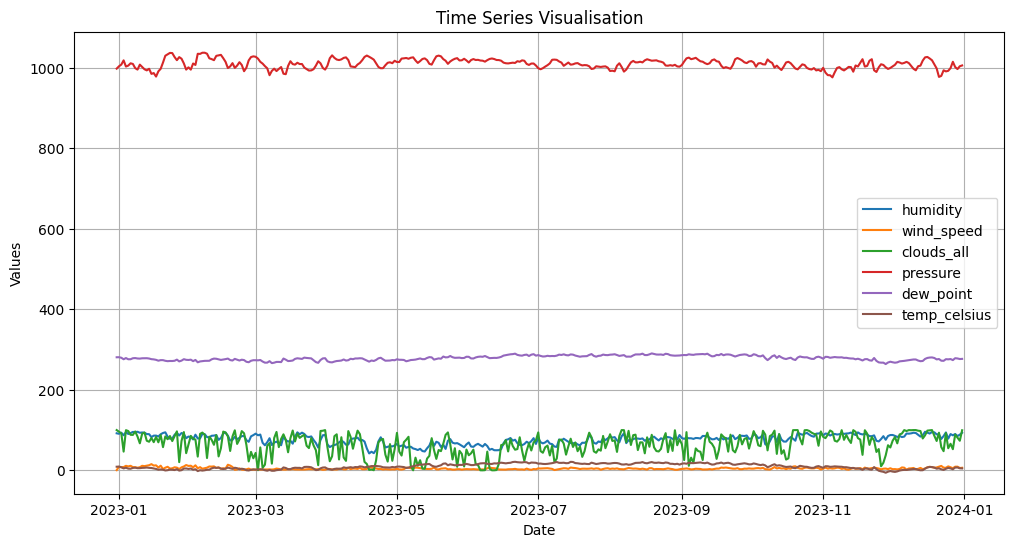

In [ ]:
plot_time_series(df)

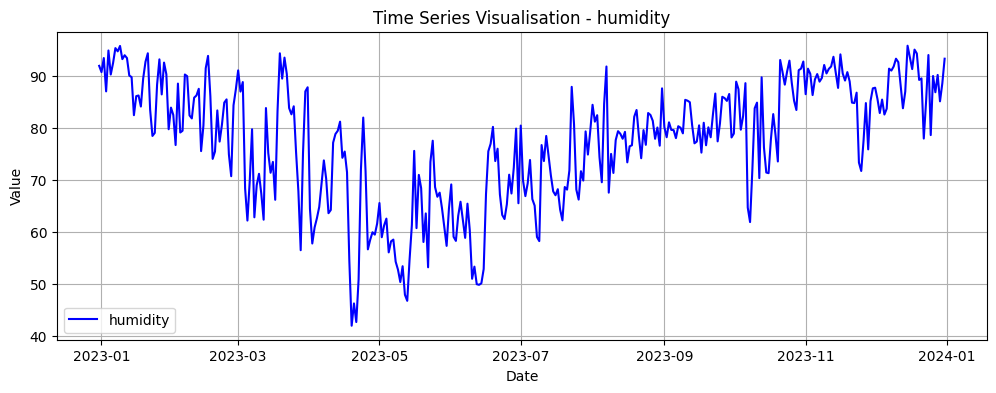

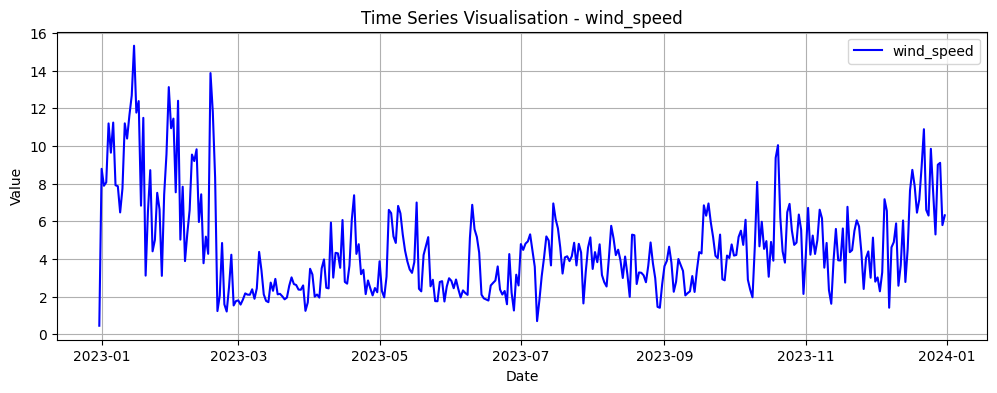

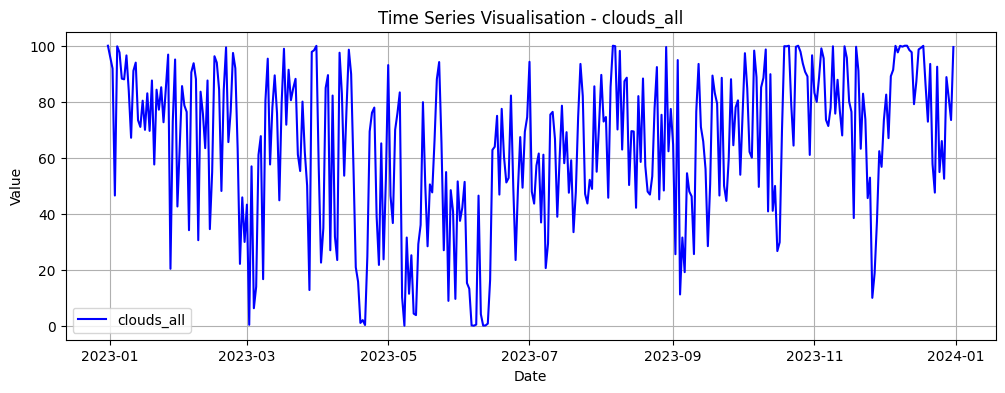

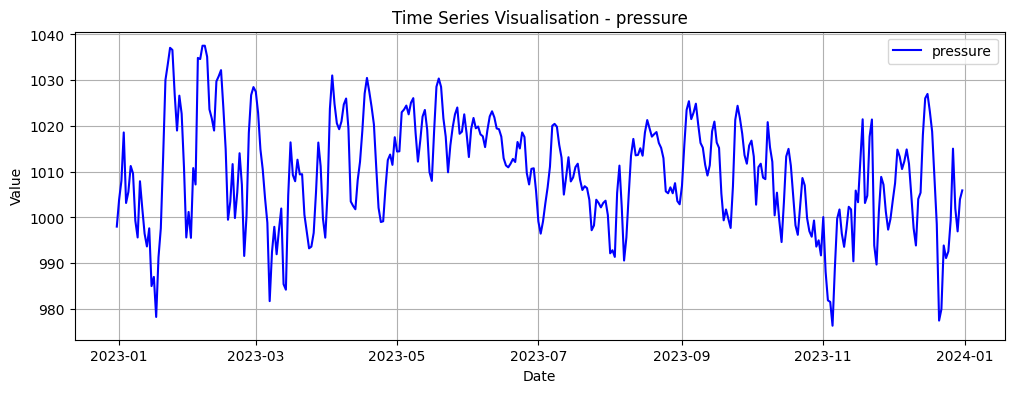

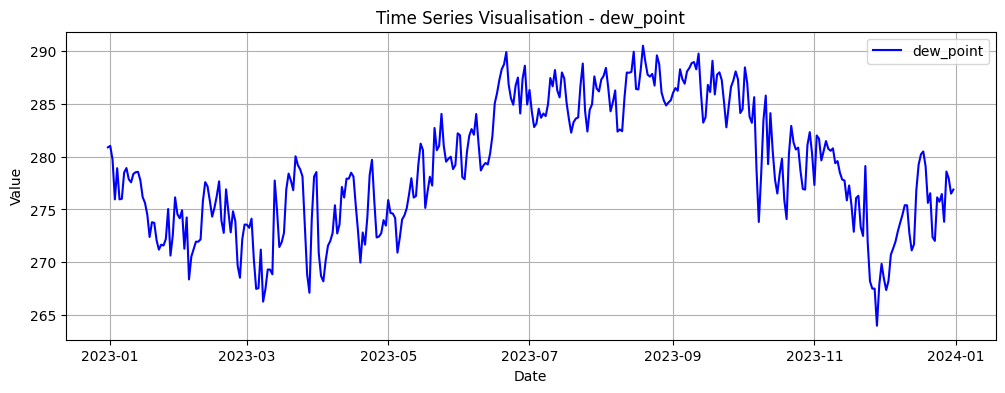

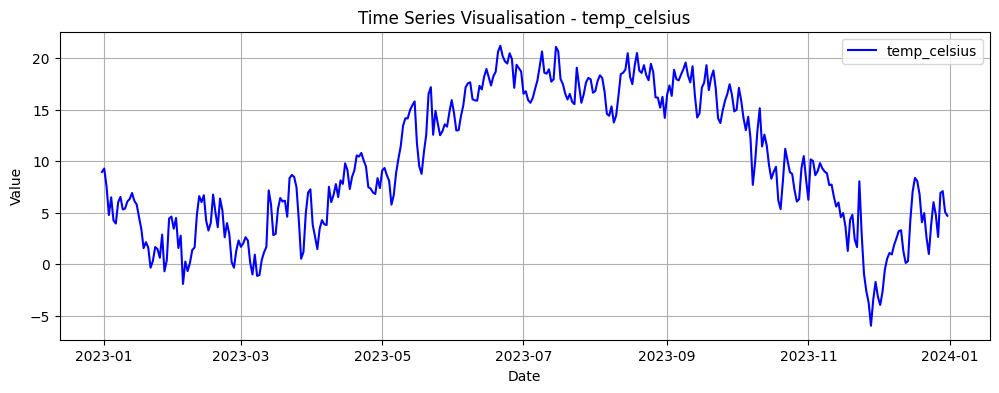

In [ ]:
plot_individual_series(df)

## Correlation Analysis

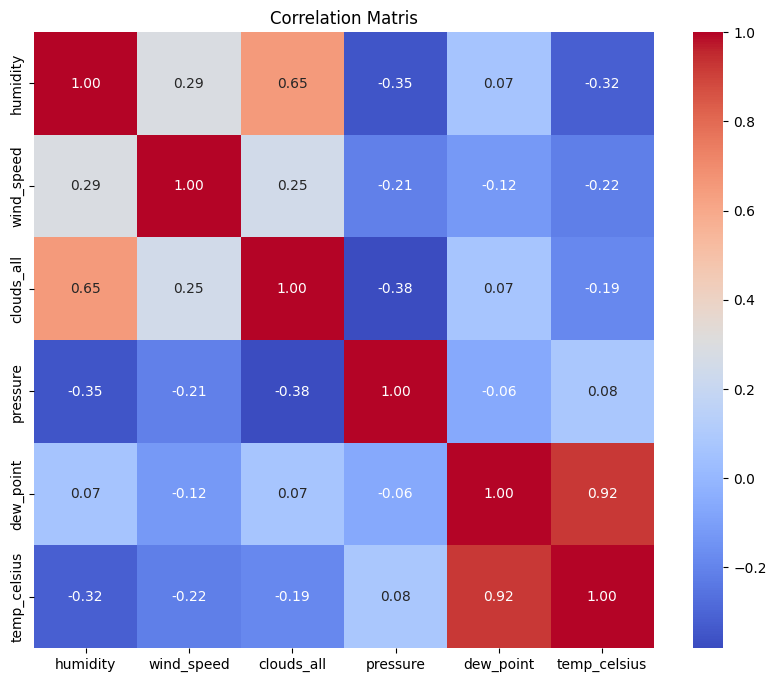

In [ ]:
plot_correlation_matrix(df)

## Anomaly Detection


In [ ]:
for column in df.columns:
    df[column + '_zscore'] = zscore(df[column])

In [ ]:
df.head()

,humidity,wind_speed,clouds_all,pressure,dew_point,temp_celsius,humidity_zscore,wind_speed_zscore,clouds_all_zscore,pressure_zscore,dew_point_zscore,temp_celsius_zscore
date,,,,,,,,,,,,
2022-12-31,92.000000,0.450000,100.000000,998.000000,280.870000,8.950000,1.222333,-1.614215,1.309496,-1.020266,0.313226,-0.134474
2023-01-01,90.791667,8.787500,96.000000,1003.916667,281.007917,9.292917,1.120684,1.656723,1.162537,-0.512624,0.336142,-0.082461
2023-01-02,93.500000,7.887500,91.833333,1008.041667,279.700833,7.535000,1.348519,1.303638,1.009454,-0.158704,0.118956,-0.349096
2023-01-03,87.083333,8.070833,46.500000,1018.583333,275.953333,4.784583,0.808725,1.375563,-0.656084,0.745757,-0.503735,-0.766269
2023-01-04,94.958333,11.200000,99.791667,1003.166667,278.899583,6.497083,1.471200,2.603186,1.301842,-0.576973,-0.014181,-0.506523


In [ ]:
anomalies = df[(df.filter(like='zscore').abs() > 3).any(axis=1)]

In [ ]:
anomalies

,humidity,wind_speed,clouds_all,pressure,dew_point,temp_celsius,humidity_zscore,wind_speed_zscore,clouds_all_zscore,pressure_zscore,dew_point_zscore,temp_celsius_zscore
date,,,,,,,,,,,,
2023-01-14,89.833333,12.683333,71.000000,997.625000,277.757500,6.155833,1.040065,3.185122,0.244041,-1.052441,-0.203952,-0.558283
2023-01-15,82.500000,15.329167,80.375000,985.000000,276.165833,5.806250,0.423157,4.223125,0.588477,-2.135649,-0.468426,-0.611306
2023-01-17,86.291667,12.387500,83.000000,978.250000,274.508333,3.433333,0.742127,3.069061,0.684919,-2.714791,-0.743838,-0.971222
2023-01-30,79.791667,13.130417,42.583333,995.625000,274.557500,4.628750,0.195322,3.360520,-0.799982,-1.224038,-0.735669,-0.789905
2023-02-03,88.583333,12.404167,76.375000,1007.208333,274.243333,2.775833,0.934910,3.075600,0.441518,-0.230203,-0.787871,-1.070949
2023-02-17,86.166667,13.875000,84.375000,999.500000,277.657083,6.762083,0.731611,3.652632,0.735436,-0.891568,-0.220637,-0.466329


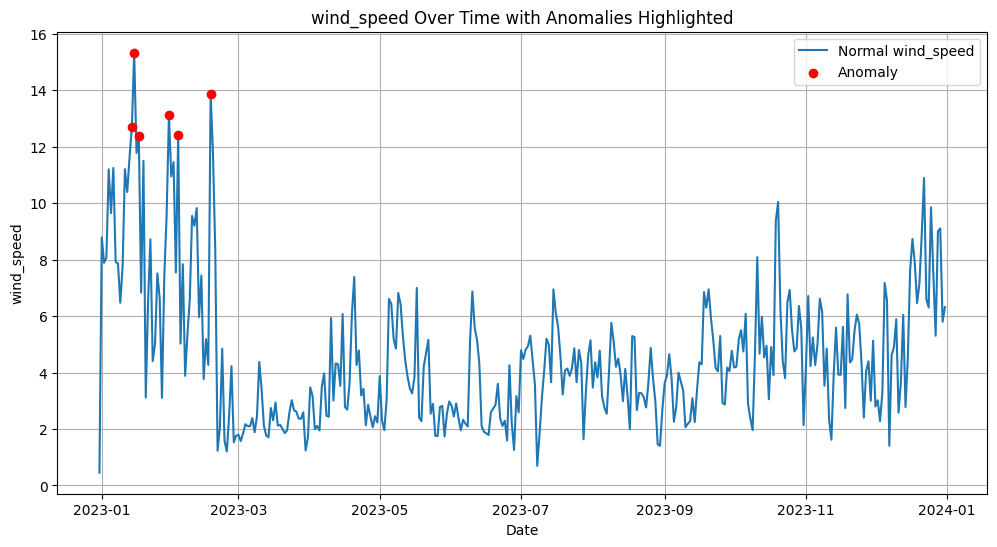

In [ ]:
plot_with_anomalies(df, anomalies, 'wind_speed')

# Time Based Train Validation Test

In [ ]:
n = len(df)

In [ ]:
train_size = int(n * 0.7)
val_size = int(n * 0.15)
test_size = n - train_size - val_size

In [ ]:
train_df = df[:train_size]

val_df = df[train_size:train_size + val_size]

test_df = df[train_size + val_size:]

In [ ]:
print(train_df.shape, val_df.shape, test_df.shape)

(256, 12) (54, 12) (56, 12)


## Scaling

In [ ]:
scaler_x = MinMaxScaler()

scaler_y = MinMaxScaler()

feature_columns = [col for col in df.columns if 'temp_celsius' not in col and 'zscore' not in col]

target_column = 'temp_celsius'

scaler_x.fit(train_df[feature_columns])

train_scaled_x = scaler_x.transform(train_df[feature_columns])

val_scaled_x = scaler_x.transform(val_df[feature_columns])

test_scaled_x = scaler_x.transform(test_df[feature_columns])


scaler_y.fit(train_df[[target_column]])

train_scaled_y = scaler_y.transform(train_df[[target_column]])

val_scaled_y = scaler_y.transform(val_df[[target_column]])

test_scaled_y = scaler_y.transform(test_df[[target_column]])

## Time Window


In [ ]:
# time_step=10


# Day:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# Temp: [15, 16, 14, 17, 18, 16, 19, 20, 21, 22, 23, 21, 20, 24, 25]

# (X): [15, 16, 14, 17, 18, 16, 19, 20, 21, 22]

# (Y): 23


# Second window:

# (X): [16, 14, 17, 18, 16, 19, 20, 21, 22, 23]

# (Y): 21


# Third window
# (X): [14, 17, 18, 16, 19, 20, 21, 22, 23, 21]

# (Y): 20

In [ ]:

# Time step = 3

# Before

# Day:        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
# Temp:   [15, 16, 14, 17, 18, 16, 19, 20, 21, 22, 23, 21, 20, 24, 25]

# After

# X = [[15, 16, 14],
#      [16, 14, 17],
#      [14, 17, 18],
#      [17, 18, 16],
#      [18, 16, 19],
#      [16, 19, 20],
#      [19, 20, 21],
#      [20, 21, 22],
#      [21, 22, 23],
#      [22, 23, 21],
#      [23, 21, 20],
#      [21, 20, 24]]

# Y = [17, 18, 16, 19, 20, 21, 22, 23, 21, 20, 24, 25]

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
window_size = 5


X_train, y_train = create_dataset(train_scaled_x, train_scaled_y.ravel(), window_size)

X_val, y_val = create_dataset(val_scaled_x, val_scaled_y.ravel(), window_size)

X_test, y_test = create_dataset(test_scaled_x, test_scaled_y.ravel(), window_size)

In [ ]:
df.shape

(366, 12)

In [ ]:
print(train_scaled_x[0], train_scaled_y[0])

[0.92884764 0.         1.         0.33309909 0.60295334] [0.46978547]


In [ ]:
X_train[0]

array([[0.92884764, 0.        , 1.        , 0.33309909, 0.60295334],
       [0.90641918, 0.56034724, 0.96      , 0.43288826, 0.6086567 ],
       [0.95668987, 0.49985998, 0.91833333, 0.50245959, 0.55460404]])

In [ ]:
y_train[0]

0.2895619253650622

# Model

## Build Model

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential([
    Input(shape=input_shape),

    SimpleRNN(50, input_shape=input_shape),

    Dense(1)
])


## Model Compile

In [ ]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

## Model Train

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size=32,
    verbose=1
)

Epoch 1/50
8/8 [==============================] - 1s 27ms/step - loss: 0.5148 - mse: 0.5148 - val_loss: 0.0656 - val_mse: 0.0656
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.1670 - mse: 0.1670 - val_loss: 0.1128 - val_mse: 0.1128
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0690 - mse: 0.0690 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0630 - mse: 0.0630 - val_loss: 0.0435 - val_mse: 0.0435
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 8/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 

## Model Performance

In [ ]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

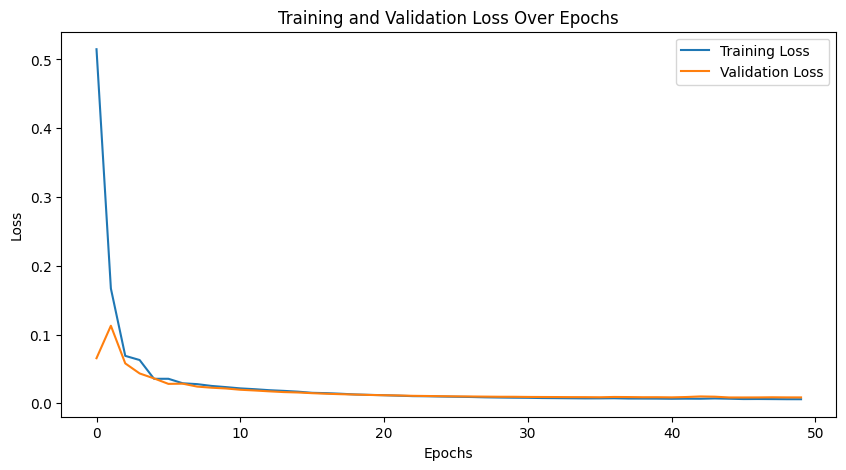

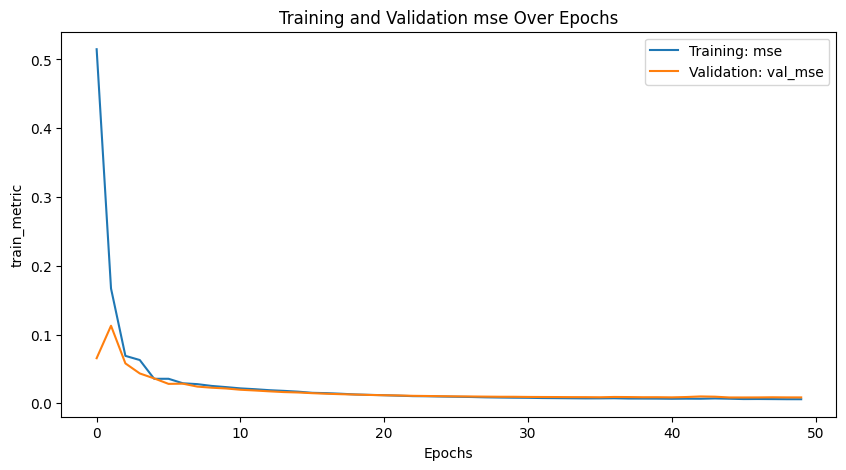

In [ ]:
plot_training_history(history, train_loss='loss', train_metric='mse', val_loss='val_loss', val_metric='val_mse')

In [ ]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Loss: 0.005940112750977278 Validation Loss: 0.008608177304267883 Test Loss: 0.01408026646822691


In [ ]:
# Loss: 0.005940112750977278 Validation Loss: 0.008608177304267883 Test Loss: 0.01408026646822691

In [ ]:
y_train_pred = model.predict(X_train, verbose=0)

y_val_pred = model.predict(X_val, verbose=0)

y_test_pred = model.predict(X_test, verbose=0)

In [ ]:
y_train_pred[0:5]

array([[0.4514611 ],
       [0.33242717],
       [0.2743573 ],
       [0.3193615 ],
       [0.33596614]], dtype=float32)

In [ ]:
true_y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

true_y_val_pred = scaler_y.inverse_transform(y_val_pred.reshape(-1, 1))

true_y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))

In [ ]:
true_y_train_pred[0:5]

array([[8.526478],
       [5.775306],
       [4.433166],
       [5.473326],
       [5.857101]], dtype=float32)

In [ ]:
true_y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

true_y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))

true_y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
train_mse = mean_squared_error(true_y_train, true_y_train_pred)

val_mse = mean_squared_error(true_y_val, true_y_val_pred)

test_mse = mean_squared_error(true_y_test, true_y_test_pred)

In [ ]:
print("Train MSE:", train_mse, "Validation MSE:", val_mse, "Test MSE:", test_mse)

Train MSE: 3.173135618953161 Validation MSE: 4.598381828182215 Test MSE: 7.5215032227643075


In [ ]:
df["temp_celsius"].mean()

9.836581284153027

In [ ]:
true_y_test[-10:]

array([[2.57583333],
       [0.99708333],
       [3.85208333],
       [6.02541667],
       [4.815     ],
       [2.65      ],
       [6.9225    ],
       [7.09541667],
       [5.07583333],
       [4.70875   ]])

In [ ]:
true_y_test_pred[-10:]

array([[6.76837  ],
       [3.8904524],
       [1.3655417],
       [1.9694326],
       [1.5641797],
       [2.11825  ],
       [3.3856292],
       [4.738573 ],
       [5.884917 ],
       [5.196523 ]], dtype=float32)

## Plot Predictions

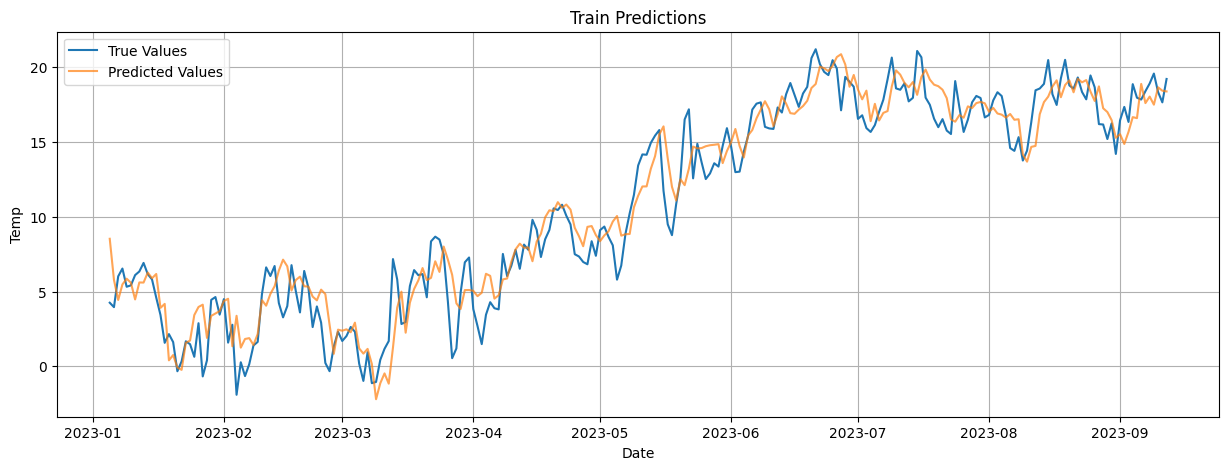

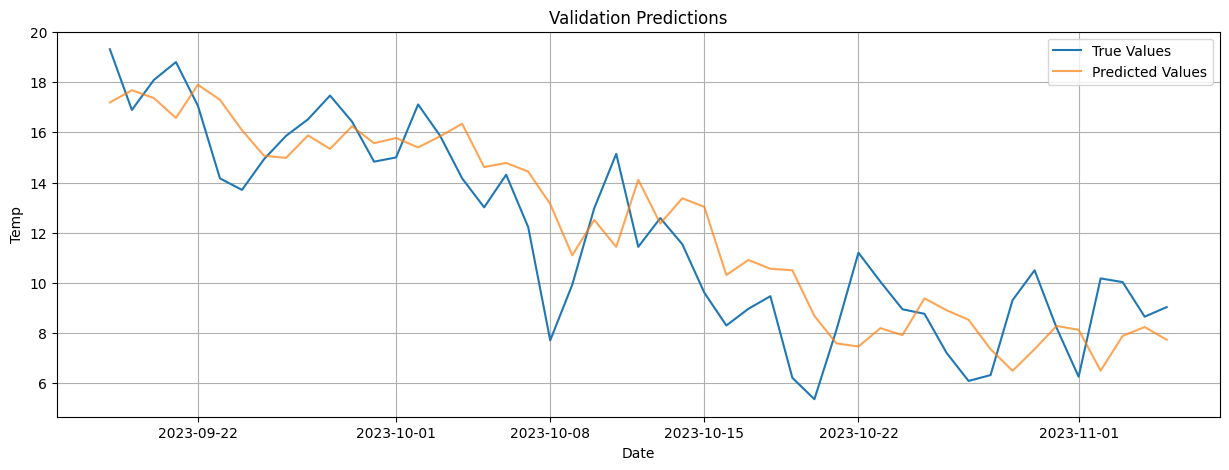

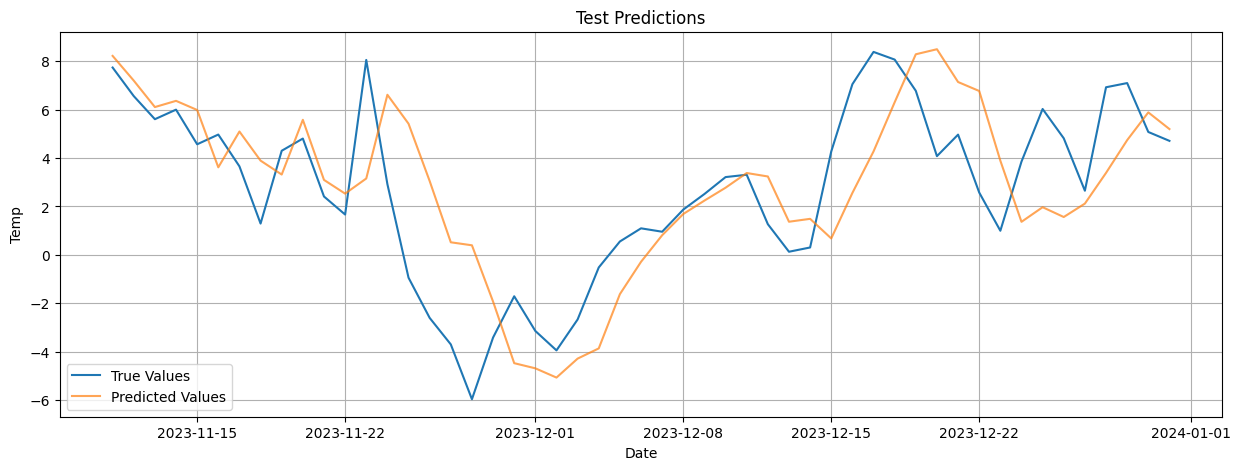

In [ ]:
time_train = train_df.index[window_size:]

time_val = val_df.index[window_size:]

time_test = test_df.index[window_size:]

plot_predictions(time_train, true_y_train, true_y_train_pred, 'Train Predictions')


plot_predictions(time_val, true_y_val, true_y_val_pred, 'Validation Predictions')

plot_predictions(time_test, true_y_test, true_y_test_pred, 'Test Predictions')


In [ ]:
def plot_all_predictions(train_df, val_df, test_df, window_size,
                     true_y_train, true_y_train_pred,
                     true_y_val, true_y_val_pred,
                     true_y_test, true_y_test_pred):

    plt.figure(figsize=(20, 10))

    # train
    train_time = train_df.index[window_size:]
    plt.plot(train_time, true_y_train, label='True Values (Train)', color='blue')
    plt.plot(train_time, true_y_train_pred, '--', label='Predicted Values (Train)', color='red')

    # validation
    val_time = val_df.index[window_size:]
    plt.plot(val_time, true_y_val, label='True Values (Validation)', color='green')
    plt.plot(val_time, true_y_val_pred, '--', label='Predicted Values (Validation)', color='orange')

    # test
    test_time = test_df.index[window_size:]
    plt.plot(test_time, true_y_test, label='True Values (Test)', color='purple')
    plt.plot(test_time, true_y_test_pred, '--', label='Predicted Values (Test)', color='pink')

    plt.title('Actual and Predicted Values for All Data Sets')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


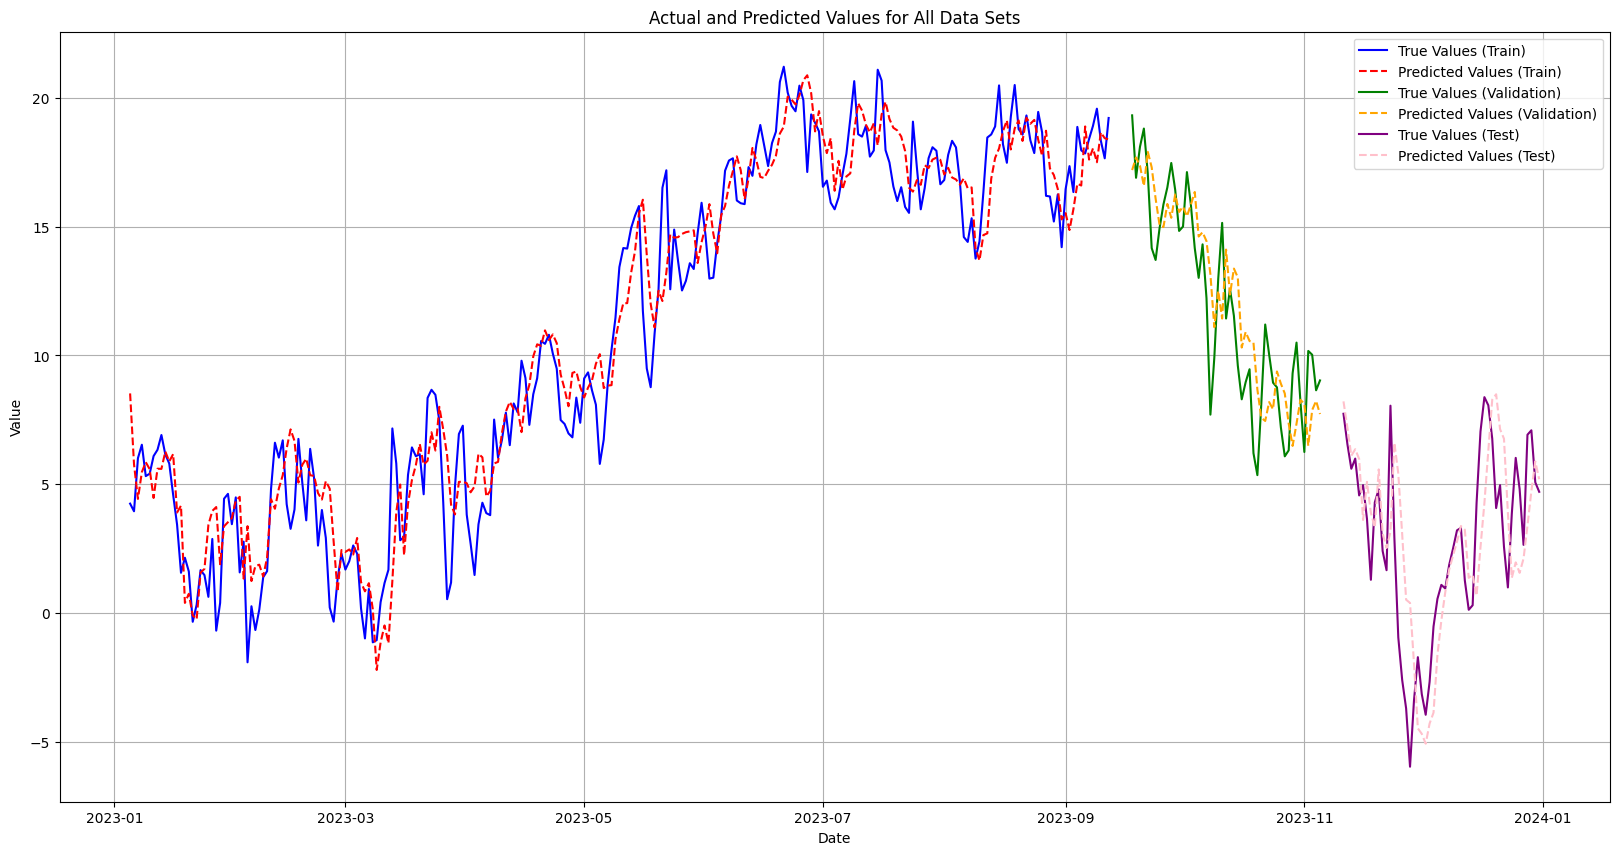

In [ ]:
plot_all_predictions(train_df=train_df,
                 val_df=val_df,
                 test_df=test_df,
                 window_size=window_size,
                 true_y_train=true_y_train,
                 true_y_train_pred=true_y_train_pred,
                 true_y_val=true_y_val,
                 true_y_val_pred=true_y_val_pred,
                 true_y_test=true_y_test,
                 true_y_test_pred=true_y_test_pred)